In [1]:
!pip uninstall -y numpy scipy scikit-learn
!pip install numpy==1.23.5 scipy==1.9.3 scikit-learn==1.1.3


Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: scipy 1.9.3
Uninstalling scipy-1.9.3:
  Successfully uninstalled scipy-1.9.3
Found existing installation: scikit-learn 1.1.3
Uninstalling scikit-learn-1.1.3:
  Successfully uninstalled scikit-learn-1.1.3
  Using cached numpy-1.23.5-cp311-cp311-macosx_10_9_x86_64.whl.metadata (2.3 kB)
  Using cached scipy-1.9.3-cp311-cp311-macosx_10_9_x86_64.whl.metadata (53 kB)
  Using cached scikit_learn-1.1.3-cp311-cp311-macosx_10_9_x86_64.whl.metadata (10 kB)
Using cached numpy-1.23.5-cp311-cp311-macosx_10_9_x86_64.whl (18.1 MB)
Using cached scipy-1.9.3-cp311-cp311-macosx_10_9_x86_64.whl (34.2 MB)
Using cached scikit_learn-1.1.3-cp311-cp311-macosx_10_9_x86_64.whl (8.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behav

In [3]:
import numpy, scipy, sklearn
print("NumPy:", numpy.__version__)
print("SciPy:", scipy.__version__)
print("scikit-learn:", sklearn.__version__)
from sklearn.feature_extraction.text import TfidfVectorizer
print("TfidfVectorizer imported successfully!")


NumPy: 1.23.5
SciPy: 1.9.3
scikit-learn: 1.1.3
TfidfVectorizer imported successfully!


In [5]:
# In[1]: Imports
import os
import pandas as pd
import numpy as np

# Surprise for CF
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV

# NearestNeighbors on latent space
from sklearn.neighbors import NearestNeighbors

# Content-based
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from collections import defaultdict


In [7]:
# In[2]: Load & clean full data
dataset_folder = "/Users/hamidahmad/Desktop/DataSet"  # ← adjust if needed

# 2.1 Products
products = pd.read_csv(os.path.join(dataset_folder, 'product_info.csv'))
products = products.rename(columns={'product_id':'itemID'})

# 2.2 Reviews
review_files = [f for f in os.listdir(dataset_folder) if f.startswith('reviews')]
reviews = pd.concat(
    [pd.read_csv(os.path.join(dataset_folder, f)) for f in review_files],
    ignore_index=True
)
reviews = reviews.rename(columns={
    'author_id':'userID',
    'product_id':'itemID',
    'rating':   'rating'
})

# 2.3 Drop missing
reviews = reviews.dropna(subset=['userID','itemID','rating'])
products = products.dropna(subset=['itemID'])

print("Products shape:", products.shape)
print("Reviews shape: ", reviews.shape)


/var/folders/y_/mwfqzzmn1dq886wqqhxb1_9m0000gn/T/ipykernel_13071/1554426862.py:11: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(dataset_folder, f)) for f in review_files],
/var/folders/y_/mwfqzzmn1dq886wqqhxb1_9m0000gn/T/ipykernel_13071/1554426862.py:11: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(dataset_folder, f)) for f in review_files],
/var/folders/y_/mwfqzzmn1dq886wqqhxb1_9m0000gn/T/ipykernel_13071/1554426862.py:11: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(dataset_folder, f)) for f in review_files],


Products shape: (8494, 27)
Reviews shape:  (1094411, 19)


In [15]:
# In[2.5]: Fast Product→User Text Embeddings (Option 2, vectorized)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition          import TruncatedSVD
import numpy as np

# 1) Product‐level TF-IDF → SVD (≈8.5k products)
prod_text   = (
    products['product_name'].fillna('') + ' ' +
    products['brand_name'].fillna('')   + ' ' +
    products['primary_category'].fillna('')
)
tfidf_prod  = TfidfVectorizer(max_features=2000, stop_words='english')
Xp          = tfidf_prod.fit_transform(prod_text)
svd_prod    = TruncatedSVD(n_components=64, random_state=42)
Xps         = svd_prod.fit_transform(Xp)

prod_cols   = [f"prod_emb_{i}" for i in range(64)]
prod_emb_df = pd.DataFrame(Xps, columns=prod_cols, index=products.index)
products    = pd.concat([products, prod_emb_df], axis=1)

# 2) Merge reviews with those embeddings
merged = reviews[['userID','itemID','rating']].merge(
    products[['itemID'] + prod_cols],
    on='itemID',
    how='left'
)

# 3) Compute rating‐weighted sums (vectorized)
merged[prod_cols] = merged[prod_cols].multiply(merged['rating'], axis=0)
user_weighted_sums = merged.groupby('userID')[prod_cols].sum()
user_sum_ratings   = merged.groupby('userID')['rating'].sum()

# 4) Divide to get weighted averages → final user text features
user_text_df = (
    user_weighted_sums
    .div(user_sum_ratings, axis=0)
    .reset_index()
)

# 5) Inspect the result
print("user_text_df shape:", user_text_df.shape)
user_text_df.head()


user_text_df shape: (578653, 257)


,userID,prod_emb_0,prod_emb_0,prod_emb_0,prod_emb_0,prod_emb_1,prod_emb_1,prod_emb_1,prod_emb_1,prod_emb_2,...,prod_emb_61,prod_emb_61,prod_emb_62,prod_emb_62,prod_emb_62,prod_emb_62,prod_emb_63,prod_emb_63,prod_emb_63,prod_emb_63
0,538863,0.128101,0.128101,0.128101,0.128101,0.128101,0.128101,0.128101,0.128101,0.128101,...,0.047713,0.047713,0.047713,0.047713,0.047713,0.047713,0.047713,0.047713,0.047713,0.047713
1,549704,0.065437,0.065437,0.065437,0.065437,0.065437,0.065437,0.065437,0.065437,0.065437,...,-0.067741,-0.067741,-0.067741,-0.067741,-0.067741,-0.067741,-0.067741,-0.067741,-0.067741,-0.067741
2,557770,0.079815,0.079815,0.079815,0.079815,0.079815,0.079815,0.079815,0.079815,0.079815,...,0.029201,0.029201,0.029201,0.029201,0.029201,0.029201,0.029201,0.029201,0.029201,0.029201
3,561736,0.103574,0.103574,0.103574,0.103574,0.103574,0.103574,0.103574,0.103574,0.103574,...,-0.090445,-0.090445,-0.090445,-0.090445,-0.090445,-0.090445,-0.090445,-0.090445,-0.090445,-0.090445
4,562130,0.068257,0.068257,0.068257,0.068257,0.068257,0.068257,0.068257,0.068257,0.068257,...,-0.024883,-0.024883,-0.024883,-0.024883,-0.024883,-0.024883,-0.024883,-0.024883,-0.024883,-0.024883


In [17]:
# In[3]: Build Surprise dataset & split
reader   = Reader(rating_scale=(1,5))
data     = Dataset.load_from_df(reviews[['userID','itemID','rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


In [19]:
# In[4]: Hyperparameter tuning & train SVD
param_grid = {
    'n_factors': [50,100,150],
    'lr_all':    [0.002,0.005],
    'reg_all':   [0.02,0.1]
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse','mae'], cv=3, n_jobs=-1)
gs.fit(data)
print("Best RMSE:", gs.best_score['rmse'])
print("Best params:", gs.best_params['rmse'])

best_params = gs.best_params['rmse']
algo_svd = SVD(**best_params)
algo_svd.fit(trainset)
pred_svd = algo_svd.test(testset)
print("Tuned SVD  → RMSE:", accuracy.rmse(pred_svd), 
      " MAE:", accuracy.mae(pred_svd))


Best RMSE: 1.0528521527077424
Best params: {'n_factors': 100, 'lr_all': 0.005, 'reg_all': 0.02}
RMSE: 1.0333
MAE:  0.7628
Tuned SVD  → RMSE: 1.0333020299714095  MAE: 0.762837986681732


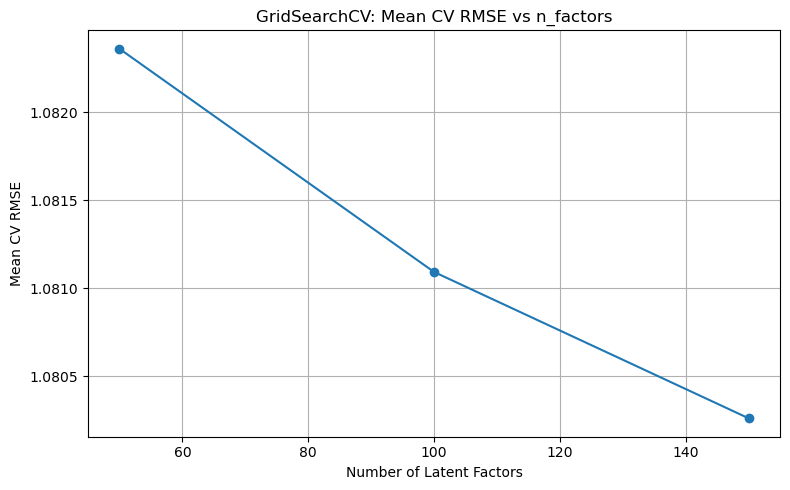

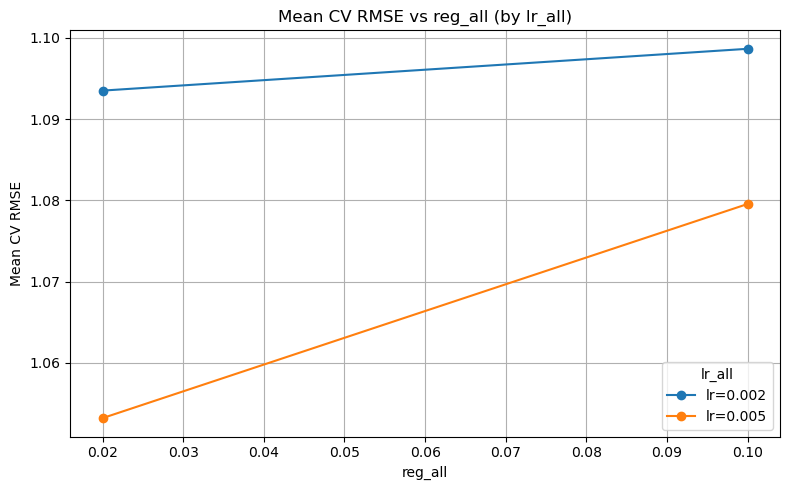

In [23]:
# In[5]: Plot GridSearchCV CV-results for SVD (fixed)

import pandas as pd
import matplotlib.pyplot as plt

# 1) Grab Surprise’s cv_results dict (no underscore)
results = pd.DataFrame(gs.cv_results)

# 2) Plot Mean RMSE vs n_factors
mean_rmse_n = (
    results
      .groupby('param_n_factors')['mean_test_rmse']
      .mean()
      .sort_index()
)

plt.figure(figsize=(8,5))
plt.plot(mean_rmse_n.index, mean_rmse_n.values, marker='o')
plt.title('GridSearchCV: Mean CV RMSE vs n_factors')
plt.xlabel('Number of Latent Factors')
plt.ylabel('Mean CV RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()


# 3) (Optional) RMSE vs reg_all for each lr_all
pivot = results.pivot_table(
    index='param_reg_all',
    columns='param_lr_all',
    values='mean_test_rmse'
)

plt.figure(figsize=(8,5))
for lr in pivot.columns:
    plt.plot(pivot.index, pivot[lr], marker='o', label=f'lr={lr}')
plt.title('Mean CV RMSE vs reg_all (by lr_all)')
plt.xlabel('reg_all')
plt.ylabel('Mean CV RMSE')
plt.legend(title='lr_all')
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
# In[5]: Latent-space CF via nearest neighbors
# extract learned factors
user_factors = algo_svd.pu    # shape: (n_users × n_factors)
item_factors = algo_svd.qi    # shape: (n_items × n_factors)

# maps between raw IDs and inner IDs
uid_map = trainset._raw2inner_id_users
iid_map = trainset._raw2inner_id_items
inner2raw_u = {inner: raw for raw, inner in uid_map.items()}
inner2raw_i = {inner: raw for raw, inner in iid_map.items()}

# build NearestNeighbors on each factor matrix
nn_user = NearestNeighbors(metric='cosine', algorithm='brute', n_jobs=-1).fit(user_factors)
nn_item = NearestNeighbors(metric='cosine', algorithm='brute', n_jobs=-1).fit(item_factors)

# CF functions in latent space
def user_cf(user_id, top_n=10):
    if user_id not in uid_map: return []
    inner = trainset.to_inner_uid(user_id)
    _, idxs = nn_user.kneighbors(user_factors[inner].reshape(1,-1), n_neighbors=top_n+1)
    return [inner2raw_u[i] for i in idxs[0] if i!=inner][:top_n]

def item_cf(item_id, top_n=10):
    if item_id not in iid_map: return []
    inner = trainset.to_inner_iid(item_id)
    _, idxs = nn_item.kneighbors(item_factors[inner].reshape(1,-1), n_neighbors=top_n+1)
    return [inner2raw_i[i] for i in idxs[0] if i!=inner][:top_n]

# examples
u0 = reviews['userID'].iloc[0]
i0 = reviews['itemID'].iloc[0]
print("User-CF neighbors for", u0, "→", user_cf(u0,5))
print("Item-CF neighbors for", i0, "→", item_cf(i0,5))


User-CF neighbors for 1741593524 → [2500872319, 1690280480, 2198743686, '29963194102', '8037437565']
Item-CF neighbors for P504322 → ['P504850', 'P478239', 'P377545', 'P427420', 'P455931']


In [29]:
# In[6]: Simplified Content-Based using 64-d product embeddings only

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 1) Pre-compute item embedding matrix and ID list
item_emb_mat = products[prod_cols].to_numpy()   # shape: [n_items × 64]
item_ids     = products['itemID'].tolist()

# 2) Turn user_text_df into an indexable DataFrame
user_emb = user_text_df.set_index('userID')

# 3) Define your content_cf by cosine similarity in 64-dim space
def content_cf(user_id, top_n=10):
    if user_id not in user_emb.index:
        return []
    # get the 64-dim user vector
    u_vec = user_emb.loc[user_id, prod_cols].values.reshape(1, -1)
    # cosine_sims to every item
    sims  = cosine_similarity(u_vec, item_emb_mat).flatten()
    # pick top_n
    idxs  = np.argsort(sims)[::-1][:top_n]
    return [(item_ids[i], sims[i]) for i in idxs]

# 4) Example output
sample_user = reviews['userID'].iloc[0]
recs = content_cf(sample_user, 5)

print(f"\nContent-based recs for user {sample_user}:")
for iid, score in recs:
    name = products.loc[products['itemID']==iid, 'product_name'].iloc[0]
    print(f"  • {iid} — {name}  (score: {score:.4f})")



Content-based recs for user 1741593524:
  • P459129 — Peptide Eye Cream  (score: 0.5152)
  • P456994 — Eye Duty Niacinamide Brightening Eye Cream  (score: 0.4821)
  • P455613 — Line-Filling Eye Cream with Bakuchiol and Caffeine  (score: 0.4814)
  • P474040 — Anti-Dandruff Scalp Serum with 2% Salicylic Acid  (score: 0.4784)
  • P467122 — That Fresh Take Eye Cream with Peptides  (score: 0.4777)


In [31]:
# In[7]: Text-Embedding–Only Recommendations

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 1) Pre-compute the item-embedding matrix (n_items × 64)
item_emb_mat = products[prod_cols].to_numpy()

# 2) Define a helper that returns top-N by cosine similarity in the 64-dim space
def content_text_recs(user_id, top_n=10):
    extra = user_text_df.set_index('userID')
    if user_id not in extra.index:
        return []
    u_vec = extra.loc[user_id, prod_cols].values.reshape(1, -1)
    sims  = cosine_similarity(u_vec, item_emb_mat).flatten()
    idxs  = np.argsort(sims)[::-1][:top_n]
    return [(products.iloc[i]['itemID'], sims[i]) for i in idxs]

# 3) Example usage
u0 = reviews['userID'].iloc[0]  # or whichever user you like
print("Text-embedding recs for", u0, "→", content_text_recs(u0, 5))


Text-embedding recs for 1741593524 → [('P459129', 0.5152375009786575), ('P456994', 0.48209657676818957), ('P455613', 0.4813773043278179), ('P474040', 0.4784263012414151), ('P467122', 0.4776502320861623)]


In [52]:
# In[8]: Three-Signal Hybrid Recommendations

def hybrid3(user_id, top_n=10, α=0.5, β=0.3):
    # 1) Collaborative (SVD)
    cf_preds  = algo_svd.test([(user_id, iid, 0) for iid in item_list])
    cf_scores = {p.iid: p.est for p in cf_preds}

    # 2) TF-IDF content
    cb_raw    = dict(content_cf(user_id, top_n=None))
    cb_scores = {iid: sim * 5 for iid, sim in cb_raw.items()}

    # 3) Text-embedding content
    txt_raw   = dict(content_text_recs(user_id, top_n=None))
    txt_scores= {iid: sim * 5 for iid, sim in txt_raw.items()}

    # 4) Blend them
    combined = {}
    for iid in item_list:
        combined[iid] = (
            α          * cf_scores.get(iid, 0) +
            β          * cb_scores.get(iid, 0) +
            (1 - α - β) * txt_scores.get(iid, 0)
        )

    # 5) Return top-N
    return sorted(combined.items(), key=lambda x: x[1], reverse=True)[:top_n]

# Example
u0 = reviews['userID'].iloc[0]
print("Hybrid3 recs for", u0, "→", hybrid3(u0, 5, α=0.6, β=0.2))


Hybrid3 recs for 1741593524 → [('P459129', 3.951755777805313), ('P459130', 3.877246276574364), ('P459128', 3.826942987418207), ('P505142', 3.7871247668508894), ('P472302', 3.7388915088297803)]


In [60]:
# In[9]: Quick P@10 & R@10 for SVD, CB, TXT, Hybrid (100-user sample)

import random
from collections import defaultdict

# --- 1) Prepare test_data: user → list of (itemID, true_rating, svd_est) ---
test_data = defaultdict(list)
for p in pred_svd:
    test_data[p.uid].append((p.iid, p.r_ui, p.est))

# --- 2) Sample 100 users (or fewer if <100) ---
users = list(test_data.keys())
sample_users = random.sample(users, min(100, len(users)))

# --- 3) Threshold and k ---
threshold = 4.0
k = 10

# --- 4) Accumulators for each method ---
metrics = {name: {'prec': [], 'rec': []}
           for name in ['SVD','CB','TXT','H3']}

# --- 5) For each sampled user, compute P@10/R@10 ---
for uid in sample_users:
    records = test_data[uid]   # list of (iid, true, est)
    relevant = {iid for iid, true, _ in records if true >= threshold}
    if not relevant:
        continue

    # SVD top-10 by svd_est
    rec_svd = [iid for iid,_,est in sorted(records, key=lambda x: x[2], reverse=True)[:k]]

    # TF-IDF content-based
    rec_cb  = [iid for iid,_ in content_cf(uid, top_n=k)]

    # Text-embedding content-based
    rec_txt = [iid for iid,_ in content_text_recs(uid, top_n=k)]

    # Hybrid
    rec_h3  = [iid for iid,_ in hybrid3(uid, top_n=k, α=0.5, β=0.3)]

    # helper to compute precision & recall
    def pr(rec_list):
        hit = len(set(rec_list) & relevant)
        return (hit/len(rec_list) if rec_list else 0.0,
                hit/len(relevant))

    for name, rec_list in [('SVD', rec_svd), ('CB', rec_cb),
                           ('TXT', rec_txt), ('H3', rec_h3)]:
        p, r = pr(rec_list)
        metrics[name]['prec'].append(p)
        metrics[name]['rec'].append(r)

# --- 6) Print the averages ---
for name in ['SVD','CB','TXT','H3']:
    p_avg = sum(metrics[name]['prec']) / len(metrics[name]['prec'])
    r_avg = sum(metrics[name]['rec'])  / len(metrics[name]['rec'])
    print(f"{name:4} → Precision@10: {p_avg:.3f}   Recall@10: {r_avg:.3f}")


SVD  → Precision@10: 0.972   Recall@10: 1.000
CB   → Precision@10: 0.000   Recall@10: 0.000
TXT  → Precision@10: 0.000   Recall@10: 0.000
H3   → Precision@10: 0.000   Recall@10: 0.000


In [62]:
# In[9]: Build user_features_ordered from reviews

import pandas as pd

# 1) Aggregate per user
user_features_ordered = (
    reviews
      .groupby('userID')
      .agg(
         rating_avg   = ('rating', 'mean'),
         rating_count = ('rating', 'count')
      )
      .reset_index()
)

# 2) Inspect
print("user_features_ordered shape:", user_features_ordered.shape)
user_features_ordered.head()


user_features_ordered shape: (578653, 3)


,userID,rating_avg,rating_count
0,538863,1.0,1
1,549704,5.0,1
2,557770,5.0,1
3,561736,5.0,2
4,562130,5.0,2


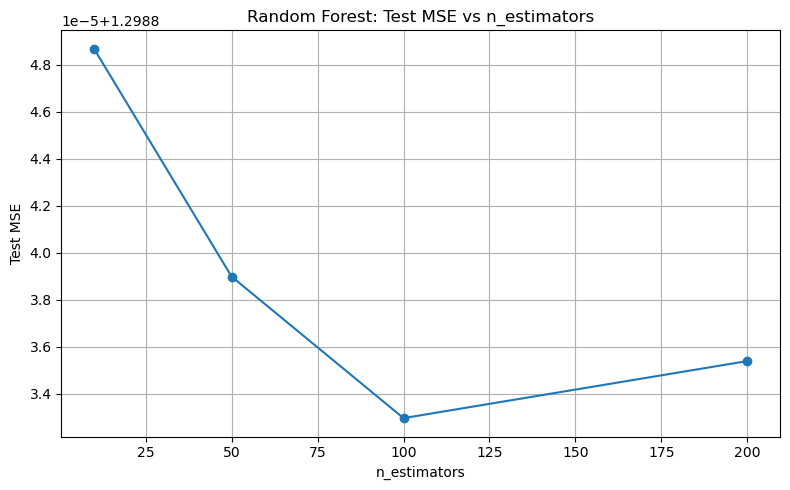

In [64]:
# In[9]: Build a user‐fingerprint regressor & plot MSE vs hyperparameters

from sklearn.model_selection import train_test_split
from sklearn.ensemble    import RandomForestRegressor
from sklearn.metrics     import mean_squared_error
import matplotlib.pyplot as plt

# 1) Prepare X/y
X = user_features_ordered.drop(columns=['userID','rating_avg'])
y = user_features_ordered['rating_avg']

# 2) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) Sweep n_estimators
param_list = [10, 50, 100, 200]
mse_list   = []

for n in param_list:
    rf = RandomForestRegressor(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mse_list.append(mean_squared_error(y_test, y_pred))

# 4) Plot
plt.figure(figsize=(8,5))
plt.plot(param_list, mse_list, marker='o')
plt.title('Random Forest: Test MSE vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Test MSE')
plt.grid(True)
plt.tight_layout()
plt.show()
